In [1]:
using ComputationalHeatTransfer

In [2]:
# using Plots
using LaTeXStrings
using Plots
pyplot()

Plots.PyPlotBackend()

In [3]:
using JLD

In [4]:
# using Revise
# using LinearAlgebra
# using DifferentialEquations
# using Interpolations
# using Plots
# pyplot()

In [5]:
# cd(dirname(pwd()))
# cd("src") 

# includet("OneDOHP.jl")
# using ..OneDOHP

### Physical parameters

In [6]:
ρ = 2702;
c = 9.03e02;
k = 2.37e02;
d = 2e-3;
params = HeatConductionParameters(ρ,c,k,thickness=d)

HeatConductionParameters(2702.0, 903.0, 237.0, 9.713488962279695e-5, 0.002)

### Geometry parameters

In [7]:
Lx = 0.1524
Ly = 0.0648;
inch = 2.54e-2;

In [8]:
xlim = (-Lx/2,Lx/2) .* 1.1
ylim = (-Ly/2,Ly/2) .* 1.1
# Δx, Δt = setstepsizes(params.α,gridPe=0.1,fourier=200.0)
Δx, Δt = setstepsizes(params.α,gridPe=8.0,fourier=0.15)
# Δx, Δt = setstepsizes(params.α,gridPe=5.0,fourier=1000000.0)


(0.0007770791169823756, 0.0009324949403788506)

### Set up the boundary of the domain

In [9]:
bdry = Rectangle(Lx/2,Ly/2,1.5Δx)

Rectangular body with 368 points and half-lengths (0.0762,0.0324)
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


### Set up the evaporator and condenser

In [10]:
eb = Rectangle(inch,inch,1.5*Δx)
Te = RigidTransform((0.0,-0.0),0.0)
Te(eb)
cb1 = Rectangle(0.5inch,inch,1.5*Δx)
Tc = RigidTransform((-2inch,-0.0),0.0)
Tc(cb1)

cb2 = Rectangle(0.5inch,inch,1.5*Δx)
Tc = RigidTransform((2inch,-0.0),0.0)
Tc(cb2)

qe = 15500.0
hc = 2000.0
Tc = -10.0

eparams = PrescribedHeatFluxRegion(qe,eb);
cparams1 = PrescribedHeatModelRegion(hc,Tc,cb1);
cparams2 = PrescribedHeatModelRegion(hc,Tc,cb2);

### Set up the OHP

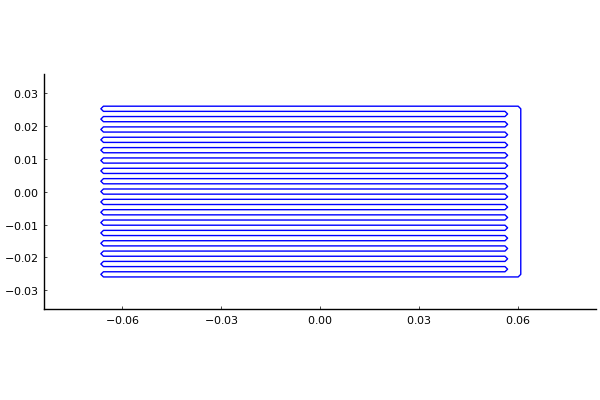

In [11]:
ds = 1.5Δx
nturn = 16
#pitch = 0.125
length_ohp = Ly*0.8
height = Lx*0.8
gap = 2*d
pitch = length_ohp/(2*nturn+1)
x0, y0 = height/2, length_ohp/2
x, y, xf, yf = ComputationalHeatTransfer.construct_ohp_curve(nturn,pitch,height,gap,ds,x0,y0,false,false,3pi/2)
ohp = BasicBody(x,y)

plot(ohp,fillalpha=0,linecolor=:blue,xlims=xlim,ylims=ylim)


In [12]:
ohpgeom = ComputationalHeatTransfer.LineSourceParams(ohp)
qtmp = zeros(numpts(ohp));

### Create the system

In [13]:
sys = HeatConduction(params,Δx,xlim,ylim,Δt,bodies=BodyList([bdry]),qline=ohpgeom,qflux=eparams,bctype=ComputationalHeatTransfer.AdiabaticBC,qmodel=[cparams1,cparams2])
#sys = HeatConduction(params,Δx,xlim,ylim,Δt,qline=ohpgeom)

Internal problem Heat conduction system on a grid of size 220 x 96 and 368 static immersed points
   1 body


#### Initialize state, and create the integrator

In [14]:
u0 = newstate(sys)
tspan = (0.0,1.0) # change this to the final time you desire


(0.0, 1.0)

### Set up values for the OHP heat flux per unit length and advance the solution

In [15]:
fill!(qtmp,-0.0)
set_linesource_strength!(sys,qtmp)

Internal problem Heat conduction system on a grid of size 220 x 96 and 368 static immersed points
   1 body


In [16]:
prob = ODEProblem(sys.f,u0,tspan,sys);
@time sol = solve(prob,ConstrainedSystems.LiskaIFHERK(),dt=timestep(sys),internal_norm=ComputationalHeatTransfer.state_norm,saveat=0.01)

110.293195 seconds (53.30 M allocations: 18.386 GiB, 2.26% gc time)


retcode: Success
Interpolation: 1st order linear
t: 101-element Array{Float64,1}:
 0.0
 0.01
 0.02
 0.03
 0.04
 0.05
 0.06
 0.07
 0.08
 0.09
 0.1
 0.11
 0.12
 ⋮
 0.89
 0.9
 0.91
 0.92
 0.93
 0.94
 0.95
 0.96
 0.97
 0.98
 0.99
 1.0
u: 101-element Array{RecursiveArrayTools.ArrayPartition{Float64,Tuple{Nodes{Primal,220,96,Float64,Array{Float64,2}},Array{Float64,1}}},1}:
 Primal nodes in a (nx = 220, ny = 96) cell grid of type Float64 data
  Number of Primal nodes: (nx = 219, ny = 95)Float64[]
 Primal nodes in a (nx = 220, ny = 96) cell grid of type Float64 data
  Number of Primal nodes: (nx = 219, ny = 95)Float64[]
 Primal nodes in a (nx = 220, ny = 96) cell grid of type Float64 data
  Number of Primal nodes: (nx = 219, ny = 95)Float64[]
 Primal nodes in a (nx = 220, ny = 96) cell grid of type Float64 data
  Number of Primal nodes: (nx = 219, ny = 95)Float64[]
 Primal nodes in a (nx = 220, ny = 96) cell grid of type Float64 data
  Number of Primal nodes: (nx = 219, ny = 95)Float64[]
 Prim

In [17]:
temperature(sol,sys,0.01)

Nodes{Primal,220,96,Float64,Array{Float64,2}} data
Printing in grid orientation (lower left is (1,1))
95×219 Array{Float64,2}:
 1.08107e-6  1.57219e-6  1.84912e-6  …  1.84912e-6  1.57219e-6  1.08107e-6
 1.47977e-6  2.21116e-6  2.62233e-6     2.62233e-6  2.21116e-6  1.47977e-6
 1.60009e-6  2.41107e-6  2.87697e-6     2.87697e-6  2.41107e-6  1.60009e-6
 1.60745e-6  2.43281e-6  2.91547e-6     2.91547e-6  2.43281e-6  1.60745e-6
 1.56722e-6  2.37887e-6  2.86094e-6     2.86094e-6  2.37887e-6  1.56722e-6
 1.50042e-6  2.28301e-6  2.75445e-6  …  2.75445e-6  2.28301e-6  1.50042e-6
 1.41268e-6  2.15428e-6  2.60688e-6     2.60688e-6  2.15428e-6  1.41268e-6
 1.30539e-6  1.99476e-6  2.42054e-6     2.42054e-6  1.99476e-6  1.30539e-6
 1.17922e-6  1.80539e-6  2.19633e-6     2.19633e-6  1.80539e-6  1.17922e-6
 1.03514e-6  1.58759e-6  1.93582e-6     1.93582e-6  1.58759e-6  1.03514e-6
 8.74671e-7  1.34364e-6  1.64174e-6  …  1.64174e-6  1.34364e-6  8.74671e-7
 6.99877e-7  1.0768e-6   1.31815e-6     1.31815e

In [18]:
tspan[2]

1.0

sys:1: UserWarning: No contour levels were found within the data range.
sys:1: UserWarning: The following kwargs were not used by contour: 'label'


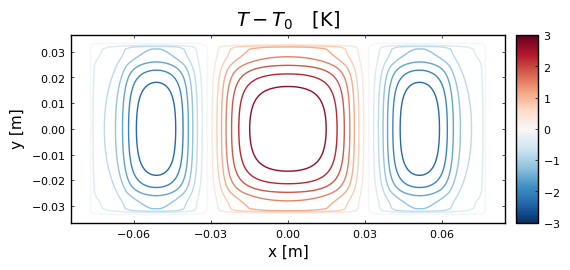

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\notebooks\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\notebooks\\tmp.gif")
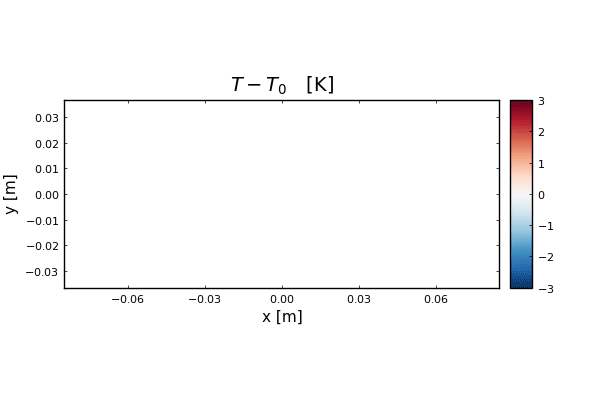

In [19]:
dt_plot = 0.01
@gif for t = tspan[1]:dt_plot:tspan[2]
    plot(temperature(sol,sys,t),sys.grid,legend=true,color=cgrad(:RdBu,rev=true),line_z=0,clim=(-3,3),xlabel="x [m]",ylabel="y [m]",title=L"T - T_0 \quad [\mathrm{K}]")
end
# plot!(ohp,fillalpha=0,line_z=qtmp)
# plot!(ohp,fillalpha=0,linecolor=:black)

In [20]:
xc, yc = coordinates(temperature(sol,sys,0.0),sys.grid);

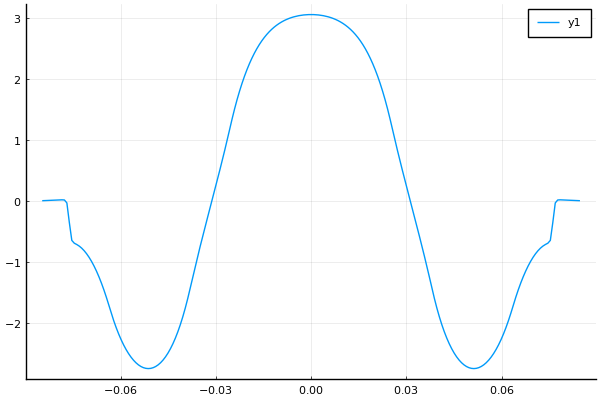

In [29]:
plot(xc,temperature(sol,sys,1.0)[:,floor(Int,size(sys.grid,2)/2)])

### Plot the temperature along the OHP channel

In [22]:
# plot(ohp,fillalpha=0,line_z=temperature_linesource(integrator))

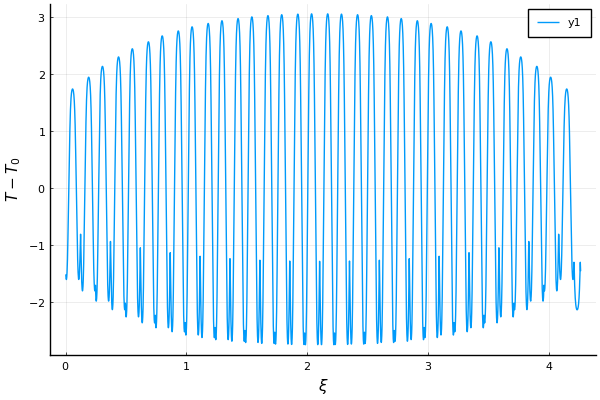

In [23]:
plot(sys.qline[1].arccoord,temperature_linesource(sol,sys,1.0),xlabel=L"\xi",ylabel=L"T - T_0")

## temperature difference without OHP

### use the same definition of heat conductance in the ASET paper (temperature based on certain locations)

In [24]:
temp_evaporator = temperature(sol,sys,1.0)[110,48]

temp_condenser_1 = temperature(sol,sys,1.0)[44,48]
temp_condenser_2 = temperature(sol,sys,1.0)[end-44+1,48]
temp_condenser  = (temp_condenser_1+temp_condenser_2)/2

tempdiff_ASET = (temp_evaporator - temp_condenser)# K

5.804790776458361

### use the same definition of heat conductance based on maximum and minimum temperatures)

In [25]:
tempdiff_maximum = maximum(temperature(sol,sys,1.0))-minimum(temperature(sol,sys,1.0))# K

5.804790776458432

## thermal conductance without OHP¶

### use the same definition of heat conductance in the ASET paper (temperature based on certain locations)

In [26]:
heater_power = 40 #watt
cond_ASET =  heater_power /tempdiff_ASET # W/K

6.890859901828354

### use the same definition of heat conductance based on maximum and minimum temperatures)

In [27]:
heater_power = 40 #watt
cond_maximum =  heater_power /tempdiff_maximum # W/K

6.89085990182827

In [30]:
save("noOHP.jld2", "sol", sol)